In [1]:
import sys
sys.path.insert(0, "..")
from src.settings import StyleSettings
from src.data.data_tools import StyleDataset
import numpy as np
import seaborn as sns


# Implementation of question 6 a custom model to try to improve performance

# Load the data

In [2]:
settings = StyleSettings()
traindataset = StyleDataset([settings.trainpath])
testdataset = StyleDataset([settings.testpath])


We have 419 batches in the dataset

In [4]:
len(traindataset) // 32


419

In [3]:
x, y = traindataset[42]
x, y


('Lace is an openwork fabric , patterned with open holes in the work , made by machine or by hand.',
 'wiki')

Every batch is a `Tuple[str, str]` of a sentence and a label. We can see this is a classification task.
The task is, to classify sentences in four categories.
Lets build a vocabulary by copy-pasting the code we used before

In [4]:
from src.models import tokenizer

corpus = []
for i in range(len(traindataset)):
    x = tokenizer.clean(traindataset[i][0])
    corpus.append(x)
v = tokenizer.build_vocab(corpus, max=20000)
len(v)


2022-06-27 11:41:43.465 | INFO     | src.models.tokenizer:build_vocab:27 - Found 19306 tokens


19308

We need to cast the labels to an integers. You can use this dictionary to do so:

In [7]:
d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
d[y]


2

# Question 2 : Implement a preprocessor

We can inherit from `tokenizer.Preprocessor`
Only thing we need to adjust is the `cast_label` function.
 
- create a StylePreprocessor class
- inherit from Preprocessor
- create a new cast_label function for this dataset

In [5]:

# TODO ~ about 4 lines of code
class StylePreprocessor(tokenizer.Preprocessor):
    def cast_label(self, label: str) -> int:
        d = {"humor": 0, "reuters": 1, "wiki": 2, "proverbs": 3}
        return d[label]
    pass


To test the preprocessor:

In [6]:
preprocessor = StylePreprocessor(max=100, vocab=v, clean=tokenizer.clean)
preprocessor([(x, y)])


(tensor([[4929,  854,   32,   15,  499,   21, 8496,  890]], dtype=torch.int32),
 tensor([2]))

# Set up the model
We can re-use the BaseDatastreamer

In [7]:
from src.data import data_tools

trainstreamer = data_tools.BaseDatastreamer(
    dataset=traindataset, batchsize=32, preprocessor=preprocessor
).stream()
teststreamer = data_tools.BaseDatastreamer(
    dataset=testdataset, batchsize=32, preprocessor=preprocessor
).stream()


In [8]:
x, y = next(trainstreamer)
x.shape, y


(torch.Size([32, 30]),
 tensor([2, 1, 1, 0, 1, 1, 1, 2, 2, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0, 1, 0, 2,
         3, 0, 0, 2, 1, 2, 0, 0]))

your explanation here

# 6 Tune the model
Don't overdo this.
More is not better.

Bonus points for things like:
- Attention layers
- Trax architecture including a functioning training loop

Keep it small! It's better to present 2 or 3 sane experiments that are structured and thought trough, than 25 random guesses. You can test more, but select 2 or 3 of the best alternatives you researched, with a rationale why this works better.

Keep it concise; explain:
- what you changed
- why you thought that was a good idea  
- what the impact was (visualise or numeric)
- explain the impact

You dont need to get a perfect score; curiousity driven research that fails is fine.
The insight into what is happening is more important than the quantity.

Keep logs of your settings;
either use gin, or save configs, or both :)
Store images in the `figures` folder.

<b>We choose to implement the model in Traxx.
We also implement a simple learning rate scheduler 

In [9]:

import jax.numpy as jnp
import trax
from trax.supervised.lr_schedules import warmup_and_rsqrt_decay
from trax.layers.assert_shape import assert_shape
from trax.layers import combinators as cb
from trax.shapes import signature
from trax import layers as tl
from typing import Dict

# implement a learning rate scheduler
lr = warmup_and_rsqrt_decay(100, 0.01)




2022-06-27 11:41:58.550559: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory


First we create a pipeline using the streamers we already have

In [10]:
def Cast():
    def f(generator):
        for x, y in generator:
            yield x.numpy(), y.numpy()

    return lambda g: f(g)

In [11]:
data_pipeline = trax.data.Serial(Cast())
trainpipe = data_pipeline(trainstreamer)
testpipe = data_pipeline(teststreamer)

In [12]:
X, y = next(trainpipe)
type(X), type(y)


(numpy.ndarray, numpy.ndarray)

We create a simple function to write to config.

In [13]:
def write_config(dir: str, config: dict, model: trax.layers.combinators.Serial) -> None:
    path = dir / "saved_config.json"
    with open(path, "w") as file:
        file.write(str(config) + str(model))

In [14]:
config = {
    "vocab": len(v),
    "hidden_size": 128,
    "features": 50,
    "output_size": 4,
    "dropout" : 0.1
}



# Models
We have a multiclass classification problem using a text sequence.
For these kinds of problems we've covered 3 models, GRU, LSTM.


In [73]:
def createCustModel(config: Dict):
    """ A Custom model using embeddings, GRU
    """
    model = tl.Serial(
        tl.Embedding(vocab_size=config["vocab"], d_feature=config["hidden_size"]), #MAP to vectors
        tl.GRU(n_units=config["hidden_size"]),  #  use a gated layer to remember words from the beginning of a text to 'understand the story'
        tl.Mean(axis=1), #  take mean values of groups of words, hopefully this generalizing will fix the overfitting we found in the last question
        tl.Dense(config["output_size"]))
    return model
model = createCustModel(config)


In [82]:
def createCustModel2(config: Dict):
    model = tl.Serial(
        tl.Embedding(vocab_size=config["vocab"], d_feature=config["hidden_size"]), #MAP to vectors
        trax.layers.rnn.LSTM(n_units=config["hidden_size"]),  #  use a lstm layer
        tl.Mean(axis=1), #  take mean values of groups of words, hopefully this generalizing will fix the overfitting we found in the last question
        tl.Dense(config["output_size"]))
    return model
model = createCustModel2(config)

In [39]:
from torch import dropout


def createCustModel3(config: Dict):
    model = tl.Serial(
        tl.Embedding(vocab_size=config["vocab"], d_feature=config["hidden_size"]), #MAP to vectors
        tl.DotProductCausalAttention(d_feature=config["hidden_size"], dropout=config["dropout"]),  #  use an attention layer
        tl.Mean(axis=1), #  take mean values of groups of words, hopefully this generalizing will fix the overfitting we found in the last question
        tl.Dense(config["output_size"]))
    return model
model = createCustModel3(config)

TypeError: __init__() got an unexpected keyword argument 'd_feature'
  In call to configurable 'DotProductCausalAttention' (<class 'trax.layers.attention.DotProductCausalAttention'>)

In [19]:
#model = tl.Serial(
#    tl.Embedding(vocab_size=8192, d_feature=50),
#    tl.Mean(axis=1),
#    tl.Dense(4),
#    tl.LogSoftmax()
#)

In [33]:
from src.models.traxmodel import summary
summary(model,X)

layer                   input                dtype     output               dtype 


AttributeError: 'tuple' object has no attribute 'shape'

In [38]:


# let's test a single prediction
model.init_weights_and_state(X)
ytest = model(X)
ytest

DeviceArray([[ 0.05987806, -0.07146724,  0.03740717,  0.00647517],
             [ 0.06435186, -0.06439573,  0.01864751, -0.02140737],
             [ 0.09703638, -0.10212536,  0.04552948,  0.03539896],
             [ 0.11896683, -0.14040262,  0.03631809,  0.01498687],
             [ 0.10195363, -0.13487253,  0.04670405,  0.03328958],
             [ 0.123125  , -0.08799148,  0.03265454,  0.04597851],
             [ 0.11343179, -0.14869706,  0.04761421,  0.04567854],
             [ 0.09762984, -0.09023017,  0.03116635,  0.0110537 ],
             [ 0.06595419, -0.07868505, -0.00846519,  0.00692413],
             [ 0.00841197, -0.00358623, -0.00811617,  0.03474265],
             [ 0.1263092 , -0.12746558,  0.0402833 ,  0.02510999],
             [ 0.10825641, -0.11145019,  0.0303273 ,  0.03073984],
             [ 0.13502723, -0.15743598,  0.044555  ,  0.04535793],
             [ 0.0998652 , -0.10309493,  0.05652996,  0.03520417],
             [ 0.09567947, -0.08366266,  0.03926584,  0.029358

In [91]:
from trax.supervised import training
import trax
from trax import layers as tl
from trax.layers import combinators as cb
from trax.layers.assert_shape import assert_shape

log_dir = "../tune"
log_dir = data_tools.dir_add_timestamp(log_dir)

write_config(log_dir, config, model)

train_task = training.TrainTask(
    labeled_data=trainpipe,
    loss_layer=tl.CategoryCrossEntropy(),
    optimizer=trax.optimizers.Adam(),
    lr_schedule=lr, # use the lossrate scheduler
    n_steps_per_checkpoint=100, 
)

eval_task = training.EvalTask(
    labeled_data=testpipe, metrics=[tl.CategoryAccuracy(), tl.CategoryCrossEntropy()], n_eval_batches=25
)

loop = training.Loop(
    model,
    train_task,
    eval_tasks=[eval_task],
    output_dir=log_dir,
)

2022-06-27 11:39:28.973 | INFO     | src.data.data_tools:dir_add_timestamp:78 - Logging to ../tune/20220627-1139
/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-AI0Wnuoo-py3.9/lib/python3.9/site-packages/jax/_src/lib/xla_bridge.py:514: UserWarning: jax.host_count has been renamed to jax.process_count. This alias will eventually be removed; please update your code.
  warnings.warn(


In [92]:
loop.run(1000)

/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-AI0Wnuoo-py3.9/lib/python3.9/site-packages/trax/layers/base.py:851: FutureWarning: GzipFile was opened for writing, but this will change in future Python releases.  Specify the mode argument for opening it for writing.
  with gzip.GzipFile(fileobj=f, compresslevel=compresslevel) as gzipf:



Step      1: Total number of trainable weights: 2603524
Step      1: Ran 1 train steps in 1.94 secs
Step      1: train CategoryCrossEntropy |  1.37543964


/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-AI0Wnuoo-py3.9/lib/python3.9/site-packages/trax/supervised/training.py:1249: FutureWarning: GzipFile was opened for writing, but this will change in future Python releases.  Specify the mode argument for opening it for writing.
  with gzip_lib.GzipFile(fileobj=f, compresslevel=2) as gzipf:


Step      1: eval      CategoryAccuracy |  0.29750000
Step      1: eval  CategoryCrossEntropy |  1.56931018

Step    100: Ran 99 train steps in 41.81 secs
Step    100: train CategoryCrossEntropy |  1.01766229
Step    100: eval      CategoryAccuracy |  0.80375000
Step    100: eval  CategoryCrossEntropy |  0.55355051

Step    200: Ran 100 train steps in 17.84 secs
Step    200: train CategoryCrossEntropy |  0.41064185
Step    200: eval      CategoryAccuracy |  0.89000000
Step    200: eval  CategoryCrossEntropy |  0.31101728

Step    300: Ran 100 train steps in 10.85 secs
Step    300: train CategoryCrossEntropy |  0.31279036
Step    300: eval      CategoryAccuracy |  0.89375000
Step    300: eval  CategoryCrossEntropy |  0.27535900

Step    400: Ran 100 train steps in 6.00 secs
Step    400: train CategoryCrossEntropy |  0.21884224
Step    400: eval      CategoryAccuracy |  0.90125000
Step    400: eval  CategoryCrossEntropy |  0.24878328

Step    500: Ran 100 train steps in 7.34 secs
Step   

: 

: 

In [65]:
# test a prediction
X, y = next(trainpipe)

yhat = model(X)
print(y[0])
print(yhat[0].argmax())


1
1


In [80]:
X, y = next(testpipe)
yhat = model(X)

for i in range(0,len(y)):
    yhati = yhat[i].argmax()
    if y[i] != yhati:
        print(str(y[i]) + "-" + str(yhati))


Let's create a new confusion matrix to see how it performs.

/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-AI0Wnuoo-py3.9/lib/python3.9/site-packages/seaborn/rcmod.py:400: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(mpl.__version__) >= "3.0":
/home/mladmin/.cache/pypoetry/virtualenvs/exam-22-AI0Wnuoo-py3.9/lib/python3.9/site-packages/setuptools/_distutils/version.py:351: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)


<AxesSubplot:xlabel='Predicted', ylabel='Target'>

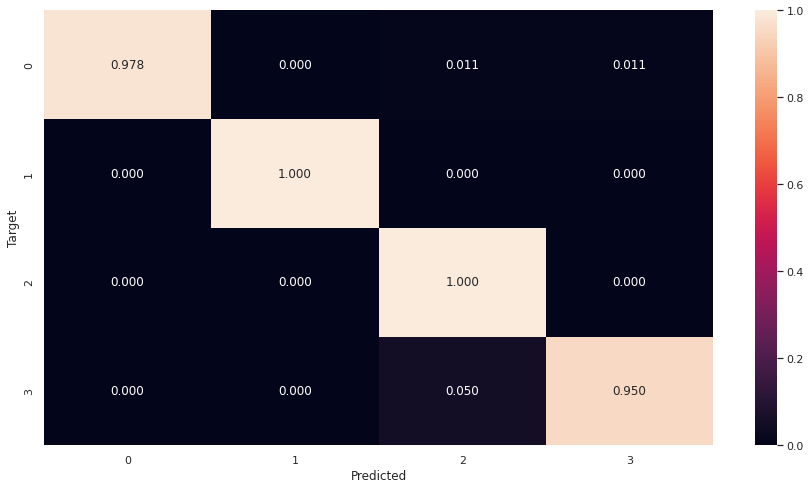

In [87]:
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
sns.set(rc = {'figure.figsize':(15,8)})
y_true = []
y_pred = []

for _ in range(10):
    X, y = next(trainpipe)
    yhat = model(X)
    predlist = list()
    truelist = list()
    for ytrue in y:
        truelist.append(int(ytrue))
    for yh1 in yhat:
        predlist.append(int(yh1.argmax()))    
    y_pred.append(predlist)
    y_true.append(truelist)


yhat = [x for y in y_pred for x in y]
y = [x for y in y_true for x in y]

cfm = confusion_matrix(y, yhat)
cfm_norm = cfm / np.sum(cfm, axis=1, keepdims=True)
plot = sns.heatmap(cfm_norm, annot=cfm_norm, fmt=".3f")
plot.set(xlabel="Predicted", ylabel="Target")
plot

Both the GRU and LSTM models perform much better then the original